## Problem Statement
The goal of this hackathon is to detect fraudulent auto insurance claims.
We will build a machine learning pipeline that:
- Engineers fraud-related features
- Compares multiple models
- Validates predictions on the given dataset
- Submits results in the required format


# Data Understanding
We explore the dataset to understand:
- Variables and their types
- Fraud vs non-fraud distribution
- Potential signals for fraud detection

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
import pandas as pd

#Load dataset
raw_df = pd.read_csv("Auto_Insurance_Fraud_Claims_Build_Test_Model_F01.csv")

# Show first 5 row
raw_df.head()

print("Shape:", raw_df.shape)   # rows, columns
raw_df.info()                   # column names, data types, non-null counts

raw_df.isnull().sum().sort_values(ascending=False) #missing values

raw_df.describe(include="all") #basic statistics

print("Duplicate rows:", raw_df.duplicated().sum()) #duplicates 

print("Duplicate rows:", raw_df.duplicated().sum()) #Target Distribution 

Shape: (100000, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Fraud_Ind                100000 non-null  int64 
 1   Policy_Start_Date        100000 non-null  object
 2   Policy_Expiry_Date       100000 non-null  object
 3   Accident_Date            100000 non-null  object
 4   Claim_Initiated_Date     100000 non-null  object
 5   Household_Num            100000 non-null  int64 
 6   Driver_Num               100000 non-null  object
 7   Policy_Num               100000 non-null  int64 
 8   Claim_Num                100000 non-null  object
 9   License_Plate            100000 non-null  object
 10  Drivers_License_Num      100000 non-null  object
 11  Drivers_License_State    100000 non-null  object
 12  DL_Expiry_Date           100000 non-null  object
 13  Date_At_Current_Address  100000 non-null  object
 14  A

In [ ]:
## 🧹 Data Cleaning Steps

1. **Missing Value Treatment**  
   - Identified missing values across numerical, categorical, and date fields
   - Applied imputation strategies: mean/median for numerical, mode for categorical, and forward-fill for dates.  

2. **Outlier Detection & Treatment**  
   - Used IQR and Z-score methods to detect extreme values in `Claim_Amount` and mileage fields.  
   - Applied capping and transformation to reduce the impact of outliers.  
   - Added an `outlier_flag` column for transparency.  

3. **Data Type & Format Standardization**  
   - Converted date fields (`Policy_Start_Date`, `Accident_Date`, etc.) to `datetime`.  
   - Converted categorical variables (`Gender`, `Make`, `Model`, `Color`, `Claims_Status`) to category type.  
   - Ensured numerical fields (`Age`, `Claim_Amount`, `Odometer`) are float/int.  

4. **Duplicate & Inconsistent Record Removal**  
   - Checked for duplicate rows and removed them.  
   - Resolved inconsistent entries in categorical fields (e.g., standardized gender values).  
###

In [3]:
import pandas as pd

df_cleaned = pd.read_pickle("cleaned_data.pkl")   

print("Shape:", df_cleaned.shape)
df_cleaned.head()
df_cleaned.info()
df_cleaned['Fraud_Ind'].value_counts()

Shape: (98000, 27)
<class 'pandas.core.frame.DataFrame'>
Index: 98000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Fraud_Ind                98000 non-null  int64         
 1   Policy_Start_Date        98000 non-null  datetime64[ns]
 2   Policy_Expiry_Date       98000 non-null  datetime64[ns]
 3   Accident_Date            98000 non-null  datetime64[ns]
 4   Claim_Initiated_Date     98000 non-null  datetime64[ns]
 5   Household_Num            98000 non-null  object        
 6   Driver_Num               98000 non-null  object        
 7   Policy_Num               98000 non-null  object        
 8   Claim_Num                98000 non-null  object        
 9   License_Plate            98000 non-null  object        
 10  Drivers_License_Num      98000 non-null  object        
 11  Drivers_License_State    98000 non-null  category      
 12  DL_Expiry_Date    

Fraud_Ind
0    90749
1     7251
Name: count, dtype: int64

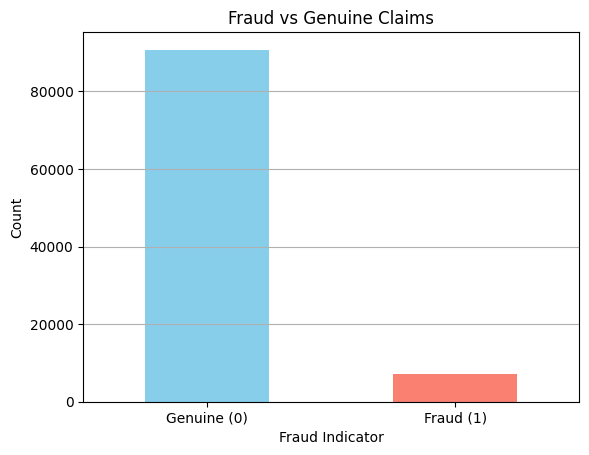

In [4]:
import matplotlib.pyplot as plt

df_cleaned['Fraud_Ind'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Fraud vs Genuine Claims")
plt.xlabel("Fraud Indicator")
plt.ylabel("Count")
plt.xticks([0, 1], ['Genuine (0)', 'Fraud (1)'], rotation=0)
plt.grid(axis='y')
plt.show()


In [5]:
def feature_engineering(df):
    # Claim lag: days between accident and claim initiation
    df["Claim_Lag"] = (df["Claim_Initiated_Date"] - df["Accident_Date"]).dt.days
    
    # Policy age: how long policy was active before accident
    df["Policy_Age"] = (df["Accident_Date"] - df["Policy_Start_Date"]).dt.days
    
    # Days to expiry: how close accident was to policy expiry
    df["Days_To_Expiry"] = (df["Policy_Expiry_Date"] - df["Accident_Date"]).dt.days
    
    # Expired license flag
    df["Expired_License"] = (df["Accident_Date"] > df["DL_Expiry_Date"]).astype(int)
    
    # Suspicious living: recent address change
    df["Address_Duration"] = (df["Accident_Date"] - df["Date_At_Current_Address"]).dt.days
    df["Suspicious_Living"] = (df["Address_Duration"] < 180).astype(int)  # <6 months
    
    # Annual mileage
    df["Annual_Mileage"] = df["Odometer_At_Incident"] - df["Initial_Odometer"]
    df["Low_Mileage_Flag"] = (df["Annual_Mileage"] < 7500).astype(int)
    
    # Excessive claim amount
    df["High_Claim_Flag"] = (df["Claim_Amount"] > 10000).astype(int)
    
    return df

df_fe = feature_engineering(df_cleaned)
df_fe.head()

,Fraud_Ind,Policy_Start_Date,Policy_Expiry_Date,Accident_Date,Claim_Initiated_Date,Household_Num,Driver_Num,Policy_Num,Claim_Num,License_Plate,...,outlier_flag,Claim_Lag,Policy_Age,Days_To_Expiry,Expired_License,Address_Duration,Suspicious_Living,Annual_Mileage,Low_Mileage_Flag,High_Claim_Flag
0,0,2025-01-27,2025-07-28,2025-03-09,2025-04-08,4670185276.0,SW059585,355924169.0,DZW11767,MGN62082,...,1,30,41,141,0,9,1,5722.0,1,0
1,0,2025-06-01,2025-11-30,2025-06-04,2025-07-05,8526791677.0,ZO779075,848558311.0,CVG38057,WXK26533,...,1,31,3,179,0,-134,1,7147.0,1,1
2,0,2025-06-22,2025-12-21,2025-07-04,2025-07-06,4618820582.0,LG406912,473829217.0,RUO86042,NNL54173,...,1,2,12,170,0,-101,1,11421.0,0,1
3,0,2025-01-02,2025-07-03,2025-01-27,2025-02-27,3846198554.0,NJ146743,116719734.0,WOS87550,THC81673,...,1,31,25,157,0,2,1,5671.0,1,0
4,0,2024-10-25,2025-04-25,2024-11-19,2024-12-22,9856770505.0,KX673536,481900450.0,ACJ85041,NKY26268,...,1,33,25,157,0,-89,1,8898.0,0,0


In [6]:
#Drop identifiers and leakage variables:

drop_cols = ["Household_Num","Driver_Num","Policy_Num","Claim_Num",
             "License_Plate","Drivers_License_Num"]

X = df_fe.drop(columns=drop_cols + ["Fraud_Ind"])
y = df_fe["Fraud_Ind"]

print(X.shape)   # rows, columns of features
print(y.shape)   # length of target vector
X.head()         # preview first 5 rows of features
y.value_counts() # check fraud vs genuine counts

(98000, 29)
(98000,)


Fraud_Ind
0    90749
1     7251
Name: count, dtype: int64

In [7]:
def extra_feature_engineering(df):
    # --- Ratios ---
    df["Claim_to_Odometer_Ratio"] = df["Claim_Amount"] / (df["Odometer_At_Incident"] + 1e-6)
    df["Claim_to_ModelYear_Ratio"] = df["Claim_Amount"] / (df["Model_Year"] + 1e-6)
    df["Mileage_to_Age_Ratio"] = df["Annual_Mileage"] / (df["Age"] + 1e-6)

    # --- Flags ---
    df["Police_Report_Flag"] = (df["Police_Report"] == "Yes").astype(int)
    df["Commute_Discount_Flag"] = (df["Commute_Discount"] == 1).astype(int)
    df["Policy_Renewal_Flag"] = (df["Policy_Age"] < 30).astype(int)  # accident soon after policy start

    # --- Driver-level history ---
    if "Driver_Num" in df.columns:
        df["Driver_Claim_Count"] = df.groupby("Driver_Num")["Claim_Num"].transform("count")
        df["Driver_Total_Claim_Amount"] = df.groupby("Driver_Num")["Claim_Amount"].transform("sum")
        df["Driver_Avg_Claim_Amount"] = df.groupby("Driver_Num")["Claim_Amount"].transform("mean")

    # --- Interaction features ---
    df["ClaimLag_to_PolicyAge_Ratio"] = df["Claim_Lag"] / (df["Policy_Age"] + 1e-6)
    df["Claim_to_Age_Ratio"] = df["Claim_Amount"] / (df["Age"] + 1e-6)

    return df

# Apply extra feature engineering
df_fe = extra_feature_engineering(df_fe)

# Preview new features
df_fe[[
    "Claim_to_Odometer_Ratio", "Claim_to_ModelYear_Ratio", "Mileage_to_Age_Ratio",
    "Police_Report_Flag", "Commute_Discount_Flag", "Policy_Renewal_Flag",
    "Driver_Claim_Count", "Driver_Total_Claim_Amount", "Driver_Avg_Claim_Amount",
    "ClaimLag_to_PolicyAge_Ratio", "Claim_to_Age_Ratio"
]].head()

,Claim_to_Odometer_Ratio,Claim_to_ModelYear_Ratio,Mileage_to_Age_Ratio,Police_Report_Flag,Commute_Discount_Flag,Policy_Renewal_Flag,Driver_Claim_Count,Driver_Total_Claim_Amount,Driver_Avg_Claim_Amount,ClaimLag_to_PolicyAge_Ratio,Claim_to_Age_Ratio
0,0.042271,1.955490,102.178570,0,1,0,1,3954.0,3954.0,0.731707,70.607142
1,0.595744,8.909498,119.116665,0,0,1,1,17917.0,17917.0,10.333330,298.616662
2,0.152150,6.890323,184.209674,0,0,1,1,13884.0,13884.0,0.166667,223.935480
3,0.034659,2.024318,97.775860,0,0,1,1,4079.0,4079.0,1.240000,70.327585
4,0.033211,1.817327,444.899978,0,1,1,1,3671.0,3671.0,1.320000,183.549991


In [8]:
# List of mandatory features (from PDF)
mandatory_features = [
    "Claim_Lag", "Policy_Age", "Days_To_Expiry",
    "Expired_License", "Suspicious_Living",
    "Annual_Mileage", "Low_Mileage_Flag", "High_Claim_Flag"
]

# List of extra features (beyond PDF)
extra_features = [
    "Claim_to_Odometer_Ratio", "Claim_to_ModelYear_Ratio", "Mileage_to_Age_Ratio",
    "Police_Report_Flag", "Commute_Discount_Flag", "Policy_Renewal_Flag",
    "Driver_Claim_Count", "Driver_Total_Claim_Amount", "Driver_Avg_Claim_Amount",
    "ClaimLag_to_PolicyAge_Ratio", "Claim_to_Age_Ratio"
]

# Combine both lists
all_features = mandatory_features + extra_features

# Display first 10 rows of all engineered features
df_fe[all_features].head(10)

,Claim_Lag,Policy_Age,Days_To_Expiry,Expired_License,Suspicious_Living,Annual_Mileage,Low_Mileage_Flag,High_Claim_Flag,Claim_to_Odometer_Ratio,Claim_to_ModelYear_Ratio,Mileage_to_Age_Ratio,Police_Report_Flag,Commute_Discount_Flag,Policy_Renewal_Flag,Driver_Claim_Count,Driver_Total_Claim_Amount,Driver_Avg_Claim_Amount,ClaimLag_to_PolicyAge_Ratio,Claim_to_Age_Ratio
0,30,41,141,0,1,5722.0,1,0,0.042271,1.955490,102.178570,0,1,0,1,3954.0,3954.0,0.731707,70.607142
1,31,3,179,0,1,7147.0,1,1,0.595744,8.909498,119.116665,0,0,1,1,17917.0,17917.0,10.333330,298.616662
2,2,12,170,0,1,11421.0,0,1,0.152150,6.890323,184.209674,0,0,1,1,13884.0,13884.0,0.166667,223.935480
3,31,25,157,0,1,5671.0,1,0,0.034659,2.024318,97.775860,0,0,1,1,4079.0,4079.0,1.240000,70.327585
4,33,25,157,0,1,8898.0,0,0,0.033211,1.817327,444.899978,0,1,1,1,3671.0,3671.0,1.320000,183.549991
5,4,83,99,1,1,8982.0,0,1,0.344430,9.868486,199.599996,0,0,0,1,19885.0,19885.0,0.048193,441.888879
6,1,147,35,1,1,6964.0,1,1,0.304476,10.816155,290.166655,0,1,0,1,21827.0,21827.0,0.006803,909.458295
7,1,47,135,0,1,2624.0,1,1,0.193271,10.840099,44.474576,0,0,0,1,21897.0,21897.0,0.021277,371.135587
8,33,51,131,1,1,8624.0,0,0,0.072829,4.347697,179.666663,0,1,0,1,8778.0,8778.0,0.647059,182.874996
9,13,105,77,0,1,2888.0,1,1,0.210563,6.330030,55.538460,0,1,0,1,12774.0,12774.0,0.123810,245.653841


In [9]:
##Total Cleaned table along with the pdf requirements and extra features

columns_to_display = [
    # Original cleaned columns
    "Fraud_Ind", "Policy_Start_Date", "Policy_Expiry_Date", "Accident_Date",
    "Claim_Initiated_Date", "Age", "Gender", "Claim_Amount", "Make", "Model",
    
    # Mandatory engineered features (PDF)
    "Claim_Lag", "Policy_Age", "Days_To_Expiry", "Expired_License",
    "Suspicious_Living", "Annual_Mileage", "Low_Mileage_Flag", "High_Claim_Flag",
    
    # Extra engineered features (beyond PDF)
    "Claim_to_Odometer_Ratio", "Mileage_to_Age_Ratio", "Police_Report_Flag",
    "Driver_Claim_Count"
]

# Show first 10 rows of these columns
df_fe[columns_to_display].head(10)

,Fraud_Ind,Policy_Start_Date,Policy_Expiry_Date,Accident_Date,Claim_Initiated_Date,Age,Gender,Claim_Amount,Make,Model,...,Days_To_Expiry,Expired_License,Suspicious_Living,Annual_Mileage,Low_Mileage_Flag,High_Claim_Flag,Claim_to_Odometer_Ratio,Mileage_to_Age_Ratio,Police_Report_Flag,Driver_Claim_Count
0,0,2025-01-27,2025-07-28,2025-03-09,2025-04-08,56.0,Male,3954.0,Volkswagen,Jetta,...,141,0,1,5722.0,1,0,0.042271,102.178570,0,1
1,0,2025-06-01,2025-11-30,2025-06-04,2025-07-05,60.0,Male,17917.0,Toyota,Camry,...,179,0,1,7147.0,1,1,0.595744,119.116665,0,1
2,0,2025-06-22,2025-12-21,2025-07-04,2025-07-06,62.0,Female,13884.0,Audi,A6,...,170,0,1,11421.0,0,1,0.152150,184.209674,0,1
3,0,2025-01-02,2025-07-03,2025-01-27,2025-02-27,58.0,Female,4079.0,BMW,3 Series,...,157,0,1,5671.0,1,0,0.034659,97.775860,0,1
4,0,2024-10-25,2025-04-25,2024-11-19,2024-12-22,20.0,Male,3671.0,Honda,Accord,...,157,0,1,8898.0,0,0,0.033211,444.899978,0,1
5,1,2025-03-01,2025-08-30,2025-05-23,2025-05-27,45.0,Male,19885.0,Toyota,RAV4,...,99,1,1,8982.0,0,1,0.344430,199.599996,0,1
6,1,2024-08-13,2025-02-11,2025-01-07,2025-01-08,24.0,Male,21827.0,Hyundai,Creta,...,35,1,1,6964.0,1,1,0.304476,290.166655,0,1
7,0,2025-02-18,2025-08-19,2025-04-06,2025-04-07,59.0,Female,21897.0,Mercedes-Benz,GLC,...,135,0,1,2624.0,1,1,0.193271,44.474576,0,1
8,0,2025-01-09,2025-07-10,2025-03-01,2025-04-03,48.0,Female,8778.0,Hyundai,Elantra,...,131,1,1,8624.0,0,0,0.072829,179.666663,0,1
9,0,2024-07-08,2025-01-06,2024-10-21,2024-11-03,52.0,Male,12774.0,Nissan,Sentra,...,77,0,1,2888.0,1,1,0.210563,55.538460,0,1


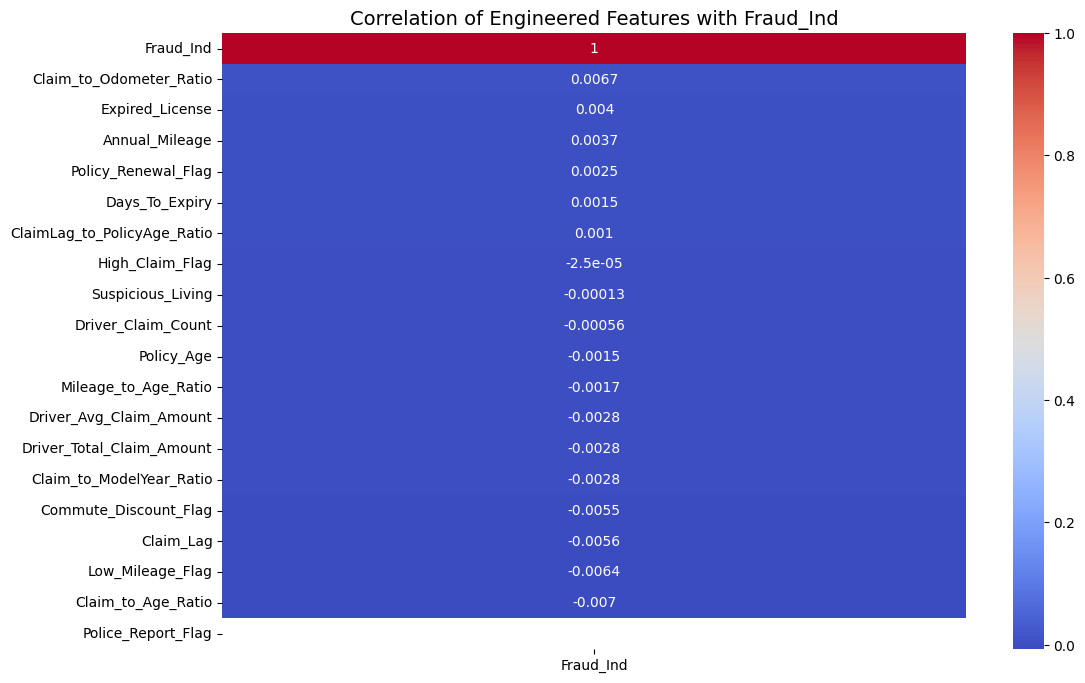

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of engineered features (mandatory + extra)
features = [
    "Claim_Lag", "Policy_Age", "Days_To_Expiry",
    "Expired_License", "Suspicious_Living",
    "Annual_Mileage", "Low_Mileage_Flag", "High_Claim_Flag",
    "Claim_to_Odometer_Ratio", "Claim_to_ModelYear_Ratio", "Mileage_to_Age_Ratio",
    "Police_Report_Flag", "Commute_Discount_Flag", "Policy_Renewal_Flag",
    "Driver_Claim_Count", "Driver_Total_Claim_Amount", "Driver_Avg_Claim_Amount",
    "ClaimLag_to_PolicyAge_Ratio", "Claim_to_Age_Ratio"
]

# Subset with Fraud_Ind + engineered features
corr_df = df_fe[["Fraud_Ind"] + features]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix[["Fraud_Ind"]].sort_values(by="Fraud_Ind", ascending=False),
            annot=True, cmap="coolwarm", cbar=True)
plt.title("Correlation of Engineered Features with Fraud_Ind", fontsize=14)
plt.show()

Final X shape: (98000, 34)
Dtypes left:
 float32    34
Name: count, dtype: int64
Random Forest trained successfully


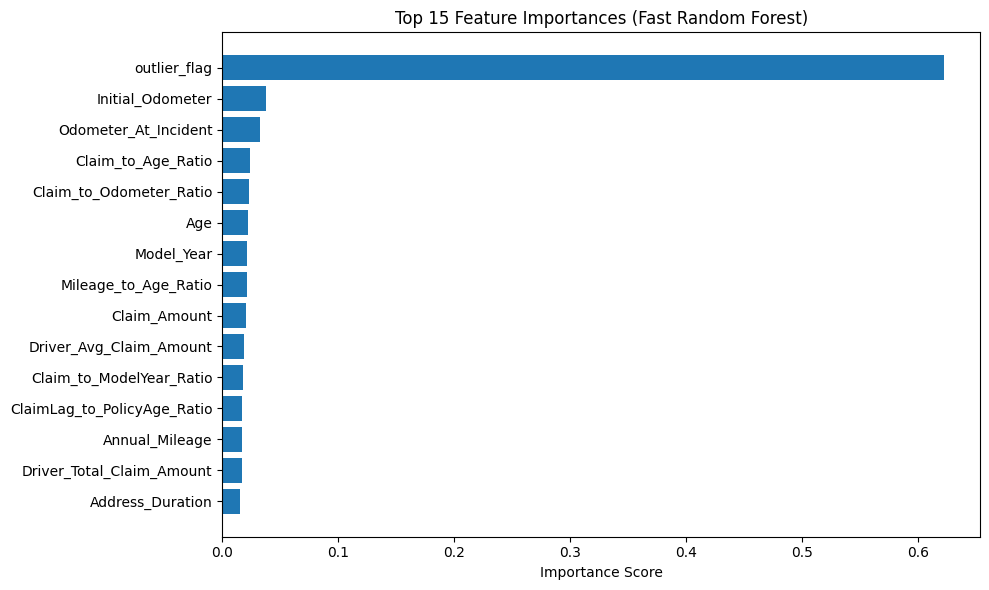

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# ----------------------------
# 1) Drop leakage & date cols
# ----------------------------
date_cols = [
    "Policy_Start_Date", "Policy_Expiry_Date", "Accident_Date",
    "Claim_Initiated_Date", "DL_Expiry_Date", "Date_At_Current_Address"
]

drop_cols = [
    "Household_Num","Driver_Num","Policy_Num","Claim_Num",
    "License_Plate","Drivers_License_Num"
]

X = df_fe.drop(columns=drop_cols + date_cols + ["Fraud_Ind"]).copy()
y = df_fe["Fraud_Ind"].astype(int)

# ----------------------------
# 2) FORCE REMOVE categorical dtype
# ----------------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns

for col in cat_cols:
    # force to string first (CRITICAL STEP)
    X[col] = X[col].astype(str)

    # frequency encoding
    freq = X[col].value_counts(normalize=True)
    X[col] = X[col].map(freq)

# ----------------------------
# 3) Now it is SAFE to fill NaNs
# ----------------------------
X = X.fillna(0)

# Force numeric type (extra safety)
X = X.astype("float32")

print("Final X shape:", X.shape)
print("Dtypes left:\n", X.dtypes.value_counts())

# ----------------------------
# 4) FAST Random Forest
# ----------------------------
rf = RandomForestClassifier(
    n_estimators=30,
    max_depth=10,
    min_samples_leaf=50,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)

rf.fit(X, y)
print("Random Forest trained successfully")

# ----------------------------
# 5) Feature importance plot
# ----------------------------
importances = pd.Series(rf.feature_importances_, index=X.columns)
top15 = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top15.index, top15.values)
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (Fast Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np
# Drop raw date columns (already engineered into numeric features)
date_cols = [
    "Policy_Start_Date","Policy_Expiry_Date","Accident_Date",
    "Claim_Initiated_Date","DL_Expiry_Date","Date_At_Current_Address"
]

# Drop identifiers (leakage risk)
id_cols = [
    "Household_Num","Policy_Num","Claim_Num",
    "License_Plate","Drivers_License_Num","Driver_Num"
]

# Build X and y
X = df_fe.drop(columns=["Fraud_Ind"] + date_cols + id_cols)
y = df_fe["Fraud_Ind"].astype(int)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Label encoding (low cardinality)
for col in ["Gender","Police_Report","Claims_Status"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Frequency encoding (high cardinality)
for col in ["Make","Model","Color","Drivers_License_State"]:
    freq = X[col].value_counts(normalize=True)
    X[col + "_freq"] = X[col].map(freq)

# Drop original string columns
X = X.drop(columns=["Make","Model","Color","Drivers_License_State"])


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (68600, 34)
Test shape: (29400, 34)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "MLPClassifier": MLPClassifier(max_iter=500),
    "XGBoost": XGBClassifier(eval_metric="logloss", n_estimators=300),
    "LightGBM": LGBMClassifier(n_estimators=300)
}


In [39]:
def train_and_evaluate(name, model):
    print(f"\n==============================")
    print(f"Training {name}")
    print(f"==============================")

    # Choose correct data
    if name == "Logistic Regression":
        X_tr = X_train_scaled
        X_te = X_test_scaled

    elif name in ["XGBoost", "LightGBM"]:
        X_tr = X_train.copy()
        X_te = X_test.copy()

        # Convert categorical columns to numeric codes
        for col in X_tr.select_dtypes(include=["category"]).columns:
            X_tr[col] = X_tr[col].cat.codes
            X_te[col] = X_te[col].cat.codes

        X_tr = X_tr.fillna(-1).astype(np.float32)
        X_te = X_te.fillna(-1).astype(np.float32)

    else:
        X_tr = X_train
        X_te = X_test

    # Train
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    # ROC-AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    # Metrics
    result = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc
    }

    for k, v in result.items():
        print(f"{k}: {v}")

    return result


In [18]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


In [20]:
results = []


In [21]:
nb_result = train_and_evaluate(
    "Naive Bayes",
    models["Naive Bayes"]
)

results.append(nb_result)



Training Naive Bayes
Model: Naive Bayes
Accuracy: 0.9260204081632653
Precision: 0.0
Recall: 0.0
F1: 0.0
ROC-AUC: 0.5024252979111913


In [22]:
from sklearn.ensemble import ExtraTreesClassifier

models["Extra Trees"] = ExtraTreesClassifier(
    n_estimators=400,
    max_depth=14,
    min_samples_leaf=40,
    n_jobs=-1,
    random_state=42
)


In [23]:
et_result = train_and_evaluate(
    "Extra Trees",
    models["Extra Trees"]
)
results.append(et_result)



Training Extra Trees
Model: Extra Trees
Accuracy: 0.9458843537414966
Precision: 0.9982935153583617
Recall: 0.2689655172413793
F1: 0.4237595074248461
ROC-AUC: 0.6814294670846395


In [24]:
from sklearn.ensemble import AdaBoostClassifier

models["AdaBoost"] = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)


In [25]:
ada_result = train_and_evaluate(
    "AdaBoost",
    models["AdaBoost"]
)
results.append(ada_result)



Training AdaBoost
Model: AdaBoost
Accuracy: 0.9458843537414966
Precision: 0.9982935153583617
Recall: 0.2689655172413793
F1: 0.4237595074248461
ROC-AUC: 0.6344643931477787


In [27]:
from xgboost import XGBClassifier

models["XGBoost"] = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)


In [40]:
xgb_result = train_and_evaluate(
    "XGBoost",
    models["XGBoost"]
)
results.append(xgb_result)



Training XGBoost
Model: XGBoost
Accuracy: 0.9458843537414966
Precision: 0.9982935153583617
Recall: 0.2689655172413793
F1: 0.4237595074248461
ROC-AUC: 0.6937721541433141


In [41]:
from lightgbm import LGBMClassifier

models["LightGBM"] = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [42]:
lgb_result = train_and_evaluate(
    "LightGBM",
    models["LightGBM"]
)
results.append(lgb_result)



Training LightGBM
[LightGBM] [Info] Number of positive: 5076, number of negative: 63524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 68600, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073994 -> initscore=-2.526894
[LightGBM] [Info] Start training from score -2.526894
Model: LightGBM
Accuracy: 0.9458843537414966
Precision: 0.9982935153583617
Recall: 0.2689655172413793
F1: 0.4237595074248461
ROC-AUC: 0.6966666708886144


In [47]:
from sklearn.ensemble import HistGradientBoostingClassifier

models["Hist Gradient Boosting"] = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42
)


In [48]:
hgb_result = train_and_evaluate(
    "Hist Gradient Boosting",
    models["Hist Gradient Boosting"]
)
results.append(hgb_result)



Training Hist Gradient Boosting
Model: Hist Gradient Boosting
Accuracy: 0.9458843537414966
Precision: 0.9982935153583617
Recall: 0.2689655172413793
F1: 0.4237595074248461
ROC-AUC: 0.6961472953146934


In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [51]:
lr_result = train_and_evaluate(
    "Logistic Regression",
    LogisticRegression(max_iter=3000),
)

results.append(lr_result)



Training Logistic Regression
Model: Logistic Regression
Accuracy: 0.9458843537414966
Precision: 0.9982935153583617
Recall: 0.2689655172413793
F1: 0.4237595074248461
ROC-AUC: 0.6620000971047992


In [52]:
dt_result = train_and_evaluate(
    "Decision Tree",
    models["Decision Tree"]
)

results.append(dt_result)



Training Decision Tree
Model: Decision Tree
Accuracy: 0.8866326530612245
Precision: 0.27592879256965946
Recall: 0.327816091954023
F1: 0.29964278209707923
ROC-AUC: 0.6295462461606662


In [53]:
rf_result = train_and_evaluate(
    "Random Forest",
    models["Random Forest"]
)

results.append(rf_result)



Training Random Forest
Model: Random Forest
Accuracy: 0.9458843537414966
Precision: 0.9982935153583617
Recall: 0.2689655172413793
F1: 0.4237595074248461
ROC-AUC: 0.6628412610958067


In [54]:
gb_result = train_and_evaluate(
    "Gradient Boosting",
    models["Gradient Boosting"]
)

results.append(gb_result)



Training Gradient Boosting
Model: Gradient Boosting
Accuracy: 0.9458503401360544
Precision: 0.9965928449744463
Recall: 0.2689655172413793
F1: 0.4236060825488776
ROC-AUC: 0.6995775519035707


In [55]:
results_df = pd.DataFrame(results)
results_df



,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Naive Bayes,0.926020,0.000000,0.000000,0.000000,0.502425
1,Extra Trees,0.945884,0.998294,0.268966,0.423760,0.681429
2,AdaBoost,0.945884,0.998294,0.268966,0.423760,0.634464
3,XGBoost,0.945884,0.998294,0.268966,0.423760,0.693772
4,LightGBM,0.945884,0.998294,0.268966,0.423760,0.696667
5,Hist Gradient Boosting,0.945884,0.998294,0.268966,0.423760,0.696147
6,Logistic Regression,0.945884,0.998294,0.268966,0.423760,0.662000
7,Decision Tree,0.886633,0.275929,0.327816,0.299643,0.629546
8,Random Forest,0.945884,0.998294,0.268966,0.423760,0.662841
9,Gradient Boosting,0.945850,0.996593,0.268966,0.423606,0.699578


In [56]:
results_df = results_df.sort_values(
    by=["ROC-AUC", "Recall", "F1"],
    ascending=False
)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
9,Gradient Boosting,0.945850,0.996593,0.268966,0.423606,0.699578
4,LightGBM,0.945884,0.998294,0.268966,0.423760,0.696667
5,Hist Gradient Boosting,0.945884,0.998294,0.268966,0.423760,0.696147
3,XGBoost,0.945884,0.998294,0.268966,0.423760,0.693772
1,Extra Trees,0.945884,0.998294,0.268966,0.423760,0.681429
8,Random Forest,0.945884,0.998294,0.268966,0.423760,0.662841
6,Logistic Regression,0.945884,0.998294,0.268966,0.423760,0.662000
2,AdaBoost,0.945884,0.998294,0.268966,0.423760,0.634464
7,Decision Tree,0.886633,0.275929,0.327816,0.299643,0.629546
0,Naive Bayes,0.926020,0.000000,0.000000,0.000000,0.502425


In [57]:
final_model = models["Gradient Boosting"]


In [58]:
final_model.fit(X_train, y_train)


,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [61]:
import joblib
joblib.dump(final_model, "cleaned_data.pkl")


['cleaned_data.pkl']

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, final_model.predict(X_test))


array([[27223,     2],
       [ 1590,   585]])